## 2. Comapre Performance

### 2.1 Project Motivation and Subject  

<p> In previous chapter, brief information about Ridge and LASSO are explained. When I first learned about these machine learning techniques, I thought LASSO would be more efficient and helpful tool as it can do the variable selection. As the course that I learned these was introductory course for machine learning, the course intended to put more weight on introducing various types of machine learning. So I moved on to the next topics without having more time to unleash my curiosity if LASSO really is a better option than Ridge. I took couple more courses about machine learning and one professor said that Ridge has better performance over LASSO when variables are highly correlated. So, in this chapter, I will generate data to compare performances in 3 different levels of correlation.  

### 2.2 Generate Data

<p> I want to generate data matrix with certain level of correlation. I first generate matrix, let's say $\rho$, with $\rho_{ii} = 1$ and $\rho_{ij} \in [-1,1]$ for $i \neq j$. I distinguished two levels of correlation, and non-diagonal entries take values as follows;
    
+ low correlation:  
$0 \leq |\rho_{ij}| \leq 0.5$  

+ high correlation:  
$0.5 < |\rho_{ij}| \leq 1$  

<p> But the correlation matrix has to be positive semi-definite to have non-negative determinant, and producing positive semi-definite matrix with desired numbers on non-diagonal entries is difficult for me. So, I choose to take a shortcut that is not mathematically proven. Be aware in mind and do not attempt to follow in somewhere official/important. 

<p> I can compute the closest positive semi-definite matrix from generated matrix. Now, this closest psd matrix will act as my correlation matrix. Repeating tens of times, I sometimes observed things like the diagonal entries are not 1 or I wanted high correlation between all variables but few variables turned to have low correlation(when p$\geq 3$). But most of the time, at least 1 pair of variables have desired correlation. 

<p> From generated correlation matrix, covariance matrix can also be generated by multiplying correlation matrix with outer product of standard deviation of variables with itself.  
    
+ Covariance Matrix($\Sigma$) = $\rho (\sigma \sigma^\top)$ 

<p> Now I can sample data from (multivariate) normal distribution.  

##### 2.2.1 Functions generating correlation and covariance matrix

In [70]:
# Import library
import matplotlib.pyplot as plt
import numpy as np
from numpy import random as random 
import pandas as pd

#` Generate closest positive semi-definite matrix from matrix
#`
#` @param A squared matrix
#` @return 'pxp' positive semi-matrix that being the closest from A
#` @detail this algorithm is proven in Higham's 1988 paper
#`         code written by tjiagoM from stackoverflow.com
#` get_near_psd: Matrix -> Matrix
def get_near_psd(A):
    C = (A + A.T)/2
    eigval, eigvec = np.linalg.eig(C)
    eigval[eigval < 0] = 0

    return eigvec.dot(np.diag(eigval)).dot(eigvec.T)

#` Generate correlation matrix of given level
#` 
#` @param nvar number of variables(p)
#` @param scale level of correlation. expecting one of 'low' or 'high'
#` @return pxp correltion-like positive semi-definite matrix
#` @detail 'low' restricts non-diagonal entries to have 0 <= abs(rho) <= 0.5
#`         'high': 0.5 < abs(rho) <= 1.0
#` gen_corr: int string -> Matrix
def gen_corr(nvar, scale={'low','high'}):
    iden_mat = np.identity(nvar)
    elem = np.empty(nvar**2-nvar)
    i = 0
    while i < (nvar**2-nvar):
        draw = random.uniform(-1,1,1)
        if scale == 'low':
            if abs(draw) <= 0.5: 
                elem[i] = draw
                i = i + 1
        elif scale == 'high':
            if abs(draw) > 0.5:
                elem[i] = draw
                i = i + 1
        else: break
  
    iden_mat[iden_mat != 1] = elem
    corr = get_near_psd(iden_mat)
    
    return corr

#` Generate covariance matrix from correlation matrix
#` 
#` @param corr pxp correlation matrix
#` @param std vector length p of standard deviation, default set to None
#` @param std_range range of std, default set to [1,5]
#` @return pxp covariance matrix
#` @detail Cov = corr * (std * std.transpose)
#`         if std is not specified, it will be sampled within std_range
#` corr2cov: Matrix Bool IntRange -> Matrix
def corr2cov(corr, std=None, std_range=[1,5]):
    nvar = corr.shape[0]
    if std is None:
        std = random.uniform(std_range[0],std_range[1],nvar)
    
    cov = corr * np.outer(std,std)

    return cov

##### 2.2.2 Data generating process

In [151]:
# Setting
random.seed(1)
nvar = 2
low, high = -5, 5 # range of means for X
nsamp = 500

# Correlation and covariance matrices
corr_low = gen_corr(nvar, 'low')
corr_high = gen_corr(nvar, 'high')

cov_low = corr2cov(corr_low)
cov_high = corr2cov(corr_high)

# Generating datapoints from multivariate normal distribution
means = np.around(random.uniform(low,high,nvar),2)
X_low = random.multivariate_normal(means,cov_low,nsamp)
X_high = random.multivariate_normal(means,cov_high,nsamp)

# Generate coefficients and finally Y
beta = np.array([np.around(random.normal(low,high,nvar),3)]).transpose()
Y_lmean = np.matmul(X_low,beta)
Y_hmean = np.matmul(X_high,beta)
Y_var = random.uniform(2,10)

Y_low = np.array([random.normal(Y_lmean,Y_var,nsamp)]).T
Y_high = np.array([random.normal(Y_hmean,Y_var,nsamp)]).T

<p> We now have generated data. Let's take a look at the data if they are properly correlated

+ low correlation

Text(0.5, 1.0, 'low correlation')

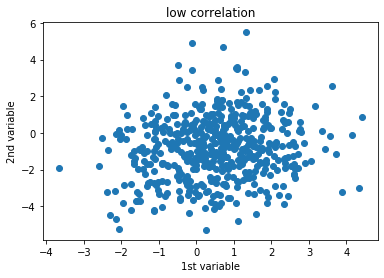

In [168]:
a =plt.scatter(X_low[:,0],X_low[:,1])
plt.ylabel('2nd variable')
plt.xlabel('1st variable')
plt.title('low correlation')

+ high correlation

Text(0.5, 1.0, 'high correlation')

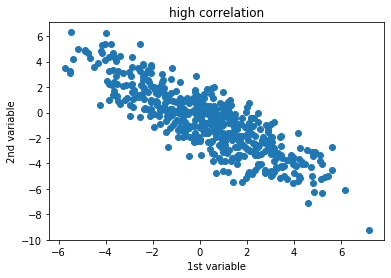

In [169]:
b = plt.scatter(X_high[:,0],X_high[:,1])
plt.ylabel('2nd variable')
plt.xlabel('1st variable')
plt.title('high correlation')

### 2.3 Fitting Ridge and LASSO

<p> Now, I need to find which penalty, $\lambda$, gives the smallest error. $\lambda$ is called tuning parameter, which literally have to be tuned to find optimal performance. The performance of $\lambda$ is evaluated with various methods, and one most famous loss function is evaluating mean squared error(MSE for short). To test the performance, the data should be splitted into two parts - training set and test set. I will use 80% of samples as training set and the rest for the test. 

In [170]:
# Split data into train and test set 
ntrain = int(0.8*nsamp) # nsamp = 500

def split_data(x,y,ntrain)
train_x_l,train_x_h = X_low[:ntrain,],X_high[:ntrain,]
train_y_l,train_y_h = Y_low[:ntrain,],Y_high[:ntrain,]
test_x_l,test_x_h = X_low[ntrain:,],X_high[ntrain:,]
test_y_l,test_y_h = Y_low[ntrain:,],Y_high[ntrain:,]

<p> Along with Ridge and LASSO, I will also fit linear regression with the train set to see if Ridge and LASSO have smaller errors than linear regression. 
    
<p> I used cross validation score from SciKit-learn library to evaluate performances with negative mean squared error as scoring function. To briefly explain what cross validation is, the data is divided into k pre-specified groups with similar size and each group becomes test set. 

In [171]:
# Import library
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

# Linear Regression
lin_reg = linear_model.LinearRegression()
lin_low = lin_reg.fit(train_x_l,train_y_l)
lin_high = lin_reg.fit(train_x_h,train_y_h)

pmse_lin_l = np.mean((lin_low.predict(test_x_l) - test_y_l)**2)
pmse_lin_h = np.mean((lin_high.predict(test_x_h) - test_y_h)**2)

print('PMSE for Linear Regression with low corr is ', np.around(pmse_lin_l,3))
print('PMSE for Linear Regression with high corr is ', np.around(pmse_lin_h,3))


PMSE for Linear Regression with low corr is  682.622
PMSE for Linear Regression with high corr is  19.65


In [156]:
# 'alpha' is tuning parameter for both Ridge and LASSO
grid = dict()
grid['alpha']=[1e-4,1e-3,0.01,0.1,1,10,100,1000]
ridge = linear_model.Ridge()
lasso = linear_model.Lasso()

# Tuning parameters
tune_ridge = GridSearchCV(ridge, grid, scoring='neg_mean_absolute_error', cv=5)
ridge_l = tune_ridge.fit(train_x_l,train_y_l)
ridge_h = tune_ridge.fit(train_x_h,train_y_h)
tune_lasso = GridSearchCV(lasso, grid, scoring='neg_mean_absolute_error', cv=5)
lasso_l = tune_lasso.fit(train_x_l,train_y_l)
lasso_h = tune_lasso.fit(train_x_h,train_y_h)

param_r_l = ridge_l.best_params_['alpha']
param_r_h = ridge_h.best_params_['alpha']
param_l_l = lasso_l.best_params_['alpha']
param_l_h = lasso_h.best_params_['alpha']

print('Best alpha for ridge with low corr is', param_r_l)
print('Best alpha for ridge with high corr is', param_r_h)
print('Best alpha for lasso with low corr is', param_l_l)
print('Best alpha for lasso with high corr is', param_l_h)

Best alpha for ridge with low corr is 1000
Best alpha for ridge with high corr is 1000
Best alpha for lasso with low corr is 10
Best alpha for lasso with high corr is 10


In [172]:
# Fit Ridge and LASSO with optimal 'alpha'
opt_ridge_l = linear_model.Ridge(alpha=param_r_l)
opt_ridge_h = linear_model.Ridge(alpha=param_r_h)
opt_lasso_l = linear_model.Lasso(alpha=param_l_l)
opt_lasso_h = linear_model.Ridge(alpha=param_l_h)

train_r_l = opt_ridge_l.fit(train_x_l,train_y_l)
train_r_h = opt_ridge_h.fit(train_x_h,train_y_h)
train_l_l = opt_lasso_l.fit(train_x_l,train_y_l)
train_l_h = opt_lasso_h.fit(train_x_h,train_y_h)

# Prediction Error
pmse_r_l = np.mean((train_r_l.predict(test_x_l) - test_y_l)**2)
pmse_r_h = np.mean((train_r_h.predict(test_x_h) - test_y_h)**2)
pmse_l_l = np.mean((train_l_l.predict(test_x_l) - test_y_l)**2)
pmse_l_h = np.mean((train_l_h.predict(test_x_h) - test_y_h)**2)

print('PMSE for ridge with low corr is ', np.around(pmse_r_l,3))
print('PMSE for ridge with high corr is ', np.around(pmse_r_h,3))
print('PMSE for lasso with low corr is ', np.around(pmse_l_l,3))
print('PMSE for lasso with high corr is ', np.around(pmse_l_h,3))

PMSE for ridge with low corr is  32.321
PMSE for ridge with high corr is  19.428
PMSE for lasso with low corr is  32.405
PMSE for lasso with high corr is  19.642


### 2.4 Results

In [173]:
result = {'Low':[pmse_lin_l,pmse_r_l,pmse_l_l],
         'High':[pmse_lin_h,pmse_r_h,pmse_l_h]}
pd.DataFrame(result, index=['LinReg','Ridge','LASSO'])

,Low,High
LinReg,682.621904,19.650057
Ridge,32.321456,19.428108
LASSO,32.404938,19.641992


<p> I first noticed that linear regression with low correlation data has extraordinarily huge prediction error than other two methods. Other than this entry, they all have similar prediction error in given condition. This is quite different result compared to what I thought. In the next chapter, I will use simulations to yield general conclusion on this topic. 